In [2]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2

import tensorflow as tf
from keras import backend as K

from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
##DATA SET
##https://www.kaggle.com/competitions/data-science-bowl-2018/data

In [7]:
with zipfile.ZipFile("../input/data-science-bowl-2018/stage1_train.zip",'r') as z:
    z.extractall("stage1_train")

with zipfile.ZipFile("../input/data-science-bowl-2018/stage2_test_final.zip",'r') as z:
    z.extractall("stage2_test_final")

In [8]:
train_path = '/kaggle/working/stage1_train/'
test_path = '/kaggle/working/stage2_test_final/'

In [9]:
train_dir = os.listdir(train_path)
test_dir = os.listdir(test_path)

First, let's create empty tensors for future images

In [12]:
X_train = np.zeros((len(train_dir), 256, 256, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_dir), 256, 256, 1), dtype=bool)

X_test = np.zeros((len(test_dir), 256, 256, 3), dtype=np.uint8)

**compressing all images** to a size of **256x256x3**, however, we will set the size of **mask images** to **256x256x1**, since it makes no sense for us to store them in **rgb format**

In [13]:
%%time
from tqdm import tqdm 
for i, name in tqdm(enumerate(train_dir)):
    path = train_path + name
    img_real = cv2.imread(path+'/images/'+ name +'.png')
    img_real = cv2.resize(img_real,(256,256))
    X_train[i] = img_real
    
    img_segment_full = np.zeros((256, 256 , 1), dtype=bool)
    segment_path = path+'/masks/'
    for name in os.listdir(segment_path):
        img_segment = cv2.imread(segment_path + name, 0)
        img_segment = cv2.resize(img_segment, (256, 256))
        img_segment = np.expand_dims(img_segment, axis=-1)
        img_segment_full = np.maximum(img_segment_full, img_segment)
    
    Y_train[i] = img_segment_full

670it [00:31, 21.07it/s]

CPU times: user 30.2 s, sys: 1.51 s, total: 31.7 s
Wall time: 31.8 s


In [14]:
%%time
for i, name in enumerate(test_dir):
    path = test_path + name
    img_real = cv2.imread(path+'/images/'+ name +'.png')
    img_real = cv2.resize(img_real, (256,256))
    X_test[i] = img_real

libpng warning: Ignoring PLTE chunk in grayscale PNG


CPU times: user 14.2 s, sys: 792 ms, total: 15 s
Wall time: 15.1 s


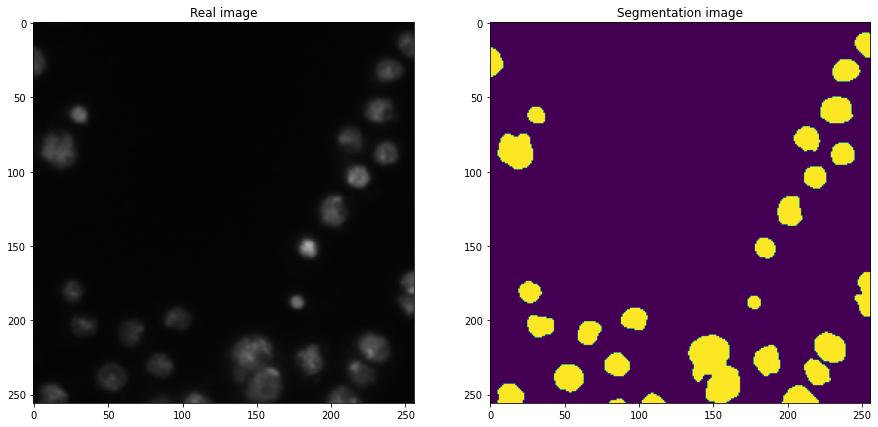

In [8]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(X_train[45])
plt.title('Real image')
plt.subplot(122)
plt.imshow(Y_train[45])
plt.title('Segmentation image');

Data preprocessing

**U-net** does not require a large amount of data, as for example for the classification task, however, there are only **670 data** in the train, I believe that **augmentation** here can improve the segmentation result

In [15]:
## DATA AUGMENTATION

aug_gen_args = dict(shear_range = 0.2,
                    zoom_range = 0.2,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='reflect'
                   )

X_train_gen = ImageDataGenerator(**aug_gen_args)
y_train_gen = ImageDataGenerator(**aug_gen_args)
X_val_gen = ImageDataGenerator()
y_val_gen = ImageDataGenerator()

##https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

To begin with, let's demonstrate on one image what augmentation looks like.

It is important to set the **seed** and **shuffle=False** in order for the **original augmented images** to match the **segmented augmented images**.

In [16]:
aug_image_real = X_train[45].reshape((1,)+X_train[1].shape)
aug_image_seg = Y_train[45].reshape((1,)+Y_train[1].shape)

In [17]:
aug_image_real_check = X_train_gen.flow(aug_image_real, batch_size=1, seed=17, shuffle=False)
aug_image_seg_check = y_train_gen.flow(aug_image_seg, batch_size=1, seed=17, shuffle=False)

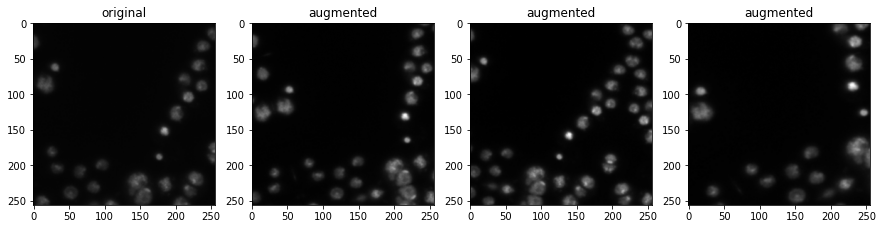

In [12]:
## IMAGE AFTER DATA AUGMENTATION
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(X_train[45])
plt.title("original")
i=2
for batch in aug_image_real_check:
    plt.subplot(14*10+i)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title("augmented")
    i += 1
    if i % 5 == 0:
        break

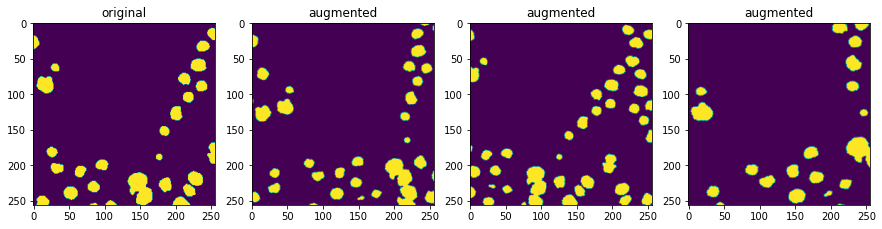

In [13]:
## MASKS AFTER AUGMENTATION
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(Y_train[45])
plt.title("original")
i=2
for batch in aug_image_seg_check:
    plt.subplot(14*10+i)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title("augmented")
    i += 1
    if i % 5 == 0:
        break

Looks good, now let's split **X_train** into **2 parts**: **train** and **val**. For val of the selection, select **0.1 data size**

Next, **apply the augmentation generators** to the train data; no augmentation will be performed for the val data

Since we need to do augmentation for original images and segmented images, then we **need to combine the generators** into one using the **zip()**

In [19]:
##TRAIN TEST SPLIT
train, val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [20]:
X_train_gen.fit(train, augment=True, seed=45)
y_train_gen.fit(y_train, augment=True, seed=45)
X_val_gen.fit(val, seed=45)
y_val_gen.fit(y_val, seed=45)

X_train_generator = X_train_gen.flow(train, batch_size=16, seed=45, shuffle=False)
y_train_generator = y_train_gen.flow(y_train, batch_size=16, seed=45, shuffle=False)
X_val_generator = X_val_gen.flow(val, batch_size=16, seed=45, shuffle=False)
y_val_generator = y_val_gen.flow(y_val, batch_size=16, seed=45, shuffle=False)

train_generator = zip(X_train_generator, y_train_generator)
val_generator = zip(X_val_generator, y_val_generator)

### IoU metric

Calculate intersection/union

![](https://images.viblo.asia/1f53756b-5271-4d27-824c-180043f47ebe.png)

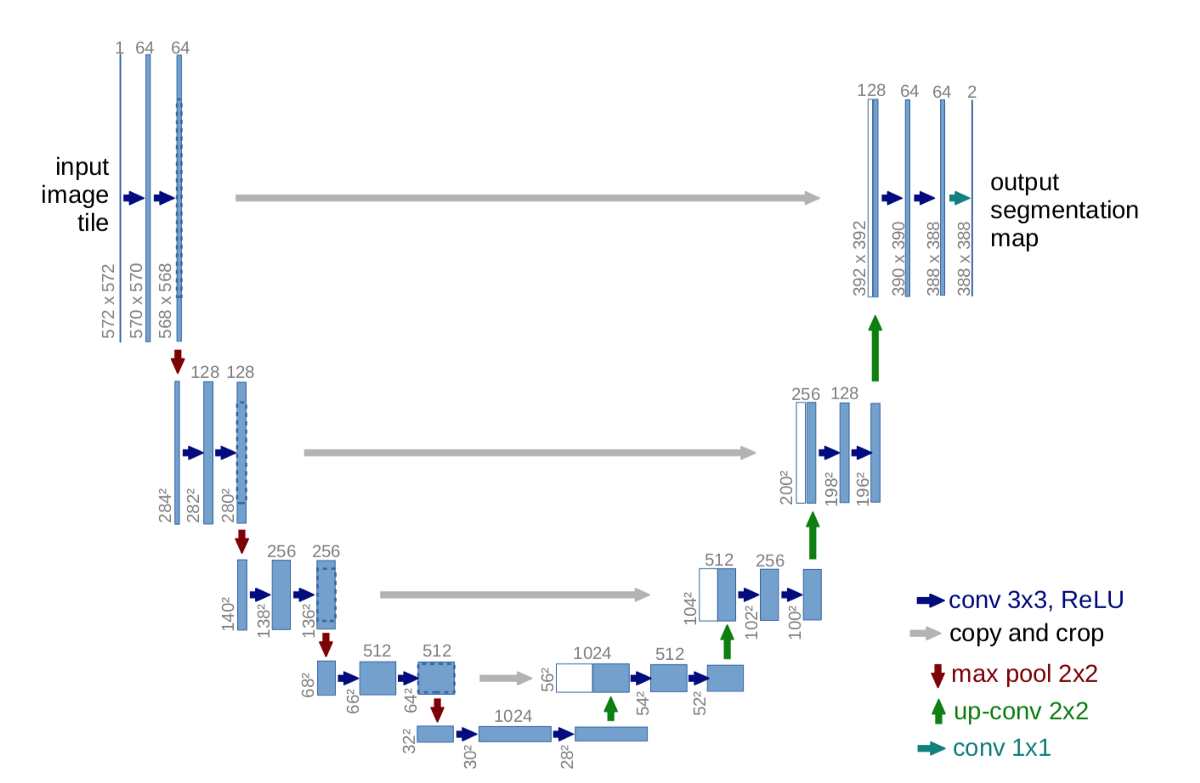

#  <center>U-net model training</center>

---------------------

In [19]:
inputs = Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs)

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = UpSampling2D(size=(2,2))(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = UpSampling2D(size=(2,2))(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = UpSampling2D(size=(2,2))(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = UpSampling2D(size=(2,2))(conv8)
up9 = concatenate([up9, conv1])
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = models.Model(inputs=[inputs], outputs=[conv10])

model.compile(optimizer=optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2),'accuracy'])


2022-09-18 11:05:28.645674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 11:05:28.745746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 11:05:28.746558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 11:05:28.747654: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [21]:
#checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss')]

#results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=1, callbacks=callbacks)




history = model.fit(train_generator,
                    steps_per_epoch=len(train)/8,
                    validation_data=val_generator,
                    validation_steps=len(val)/8,
                    epochs=75,callbacks=callbacks
                   )

2022-09-18 11:05:31.912490: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75


2022-09-18 11:05:34.283279: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


75/75 [==============================] - 39s 374ms/step - loss: 0.3082 - mean_io_u: 0.4348 - accuracy: 0.8767 - val_loss: 0.1191 - val_mean_io_u: 0.4435 - val_accuracy: 0.9529
Epoch 2/75
75/75 [==============================] - 25s 338ms/step - loss: 0.1547 - mean_io_u: 0.4349 - accuracy: 0.9242 - val_loss: 0.0846 - val_mean_io_u: 0.4443 - val_accuracy: 0.9699
Epoch 3/75
75/75 [==============================] - 25s 335ms/step - loss: 0.1346 - mean_io_u: 0.4353 - accuracy: 0.9344 - val_loss: 0.0766 - val_mean_io_u: 0.4452 - val_accuracy: 0.9723
Epoch 4/75
75/75 [==============================] - 25s 336ms/step - loss: 0.1199 - mean_io_u: 0.4358 - accuracy: 0.9388 - val_loss: 0.0725 - val_mean_io_u: 0.4441 - val_accuracy: 0.9725
Epoch 5/75
75/75 [==============================] - 25s 338ms/step - loss: 0.1013 - mean_io_u: 0.4347 - accuracy: 0.9415 - val_loss: 0.0661 - val_mean_io_u: 0.4436 - val_accuracy: 0.9742
Epoch 6/75
75/75 [==============================] - 25s 338ms/step - loss: 0

In [22]:
model.save("unet2_model.h5")

In [21]:
model = tf.keras.models.load_model("../input/kaggleworking/unet2_model.h5")

In [5]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 256, 256, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_60[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_61[0][0]                  
____________________________________________________________________________________________

#   <center>Result on train/val data</center> 

In [24]:
train_pred = model.predict(train, verbose = 1)
val_pred = model.predict(val, verbose=1)

2022-09-18 12:25:21.443373: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-18 12:25:22.910970: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3/3 [==============================] - 1s 354ms/step


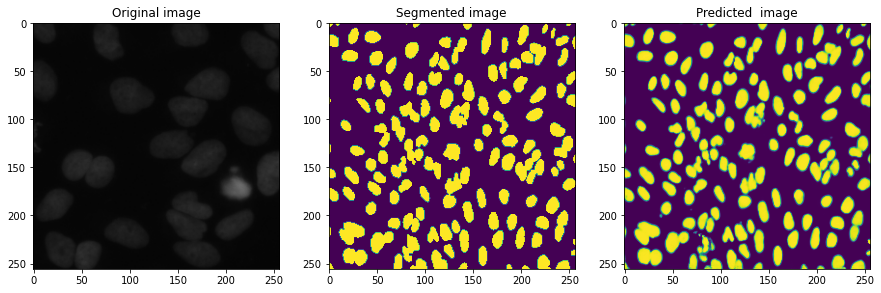

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(train[45])
plt.title('Original image')
plt.subplot(132)
plt.imshow(np.squeeze(y_train[1]))
plt.title('Segmented image')
plt.subplot(133)
plt.imshow(np.squeeze(train_pred[1]))
plt.title('Predicted  image');

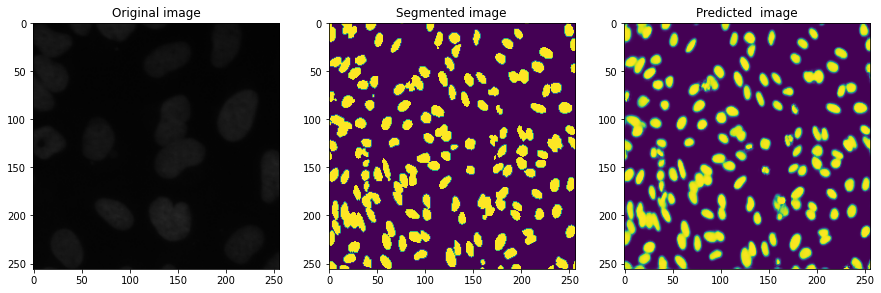

In [26]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(val[45])
plt.title('Original image')
plt.subplot(132)
plt.imshow(np.squeeze(y_val[3]))
plt.title('Segmented image')
plt.subplot(133)
plt.imshow(np.squeeze(val_pred[3]))
plt.title('Predicted  image');

Great, it looks like the neural network really works, now let's **predict** the result for **X_test data**.

#   <center>Result on test data</center>

In [28]:
test_pred = model.predict(X_test, verbose=1)

95/95 [==============================] - 9s 94ms/step


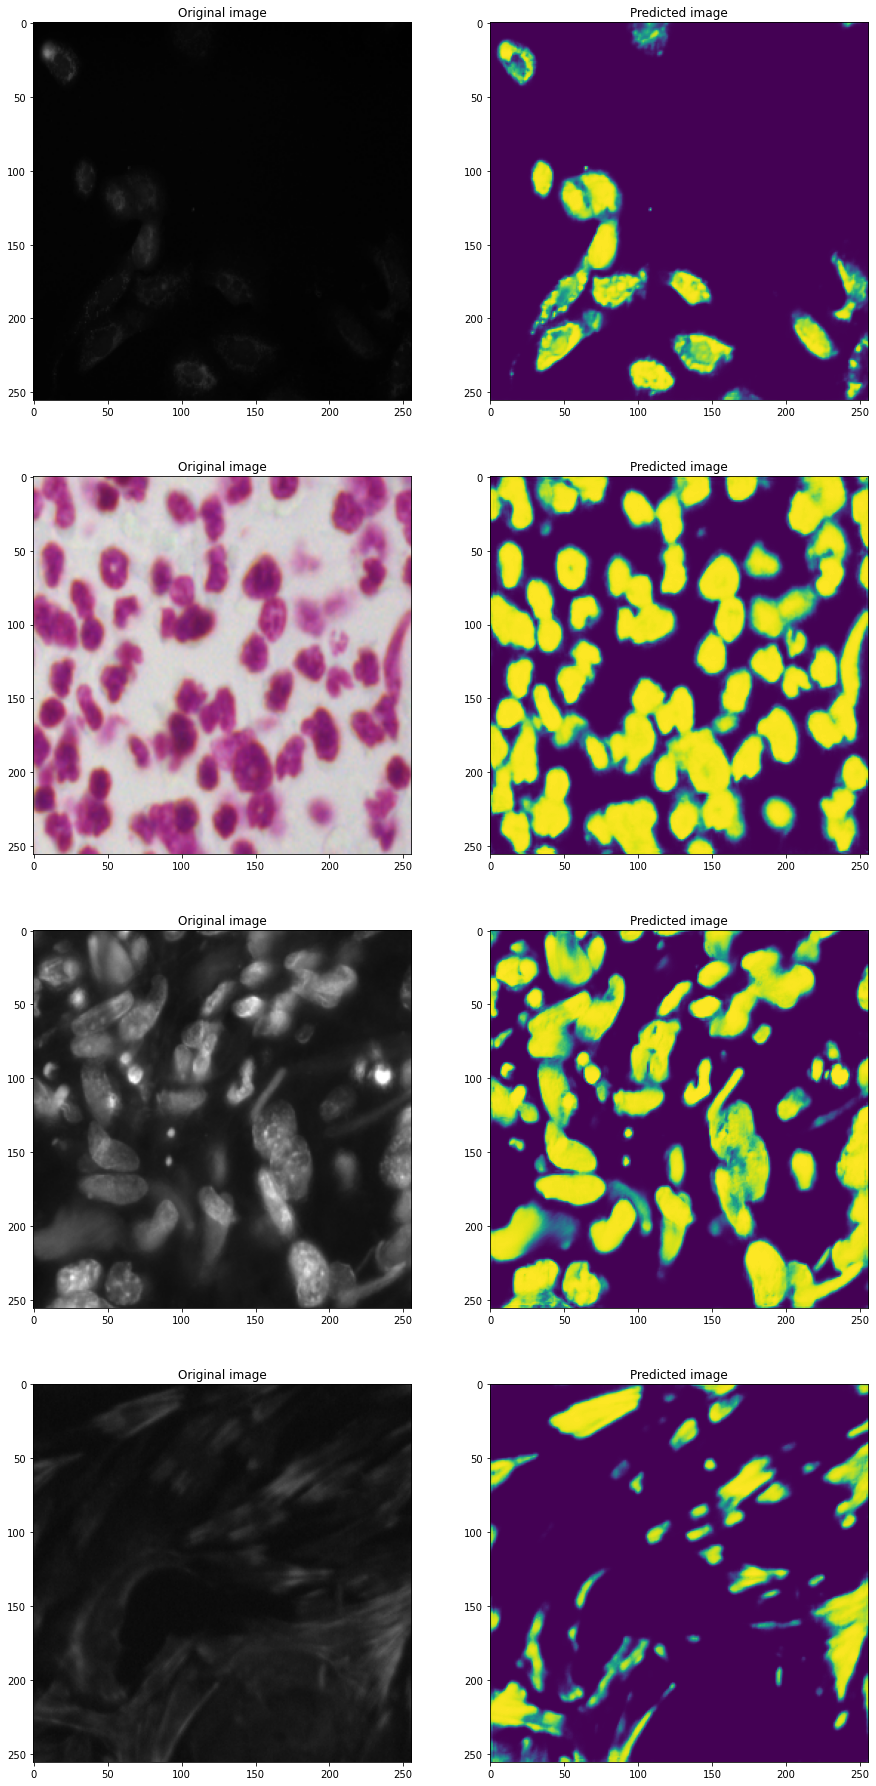

In [29]:
plt.figure(figsize=(15, 32))
for i in range(421, 429):
    plt.subplot(i)
    if i % 2!=0:
        plt.imshow(X_test[i])
        plt.title('Original image')
    else:
        plt.imshow(np.squeeze(test_pred[i-1]))
        plt.title('Predicted image')

In [ ]:
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + 1) / (union + 1), axis=0)
    return iou

In [ ]:
def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)

In [ ]:
def dice_loss(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + 1) / (union + 1), axis=0)
    return 1. - dice